<a href="https://colab.research.google.com/github/ezulfica/School-Projects/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import Image, display
pd.set_option('display.float_format', lambda x: '%.02f' % x)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, Binarizer, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.compose import ColumnTransformer

In [ ]:
from sklearn.metrics import balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.listdir('drive/MyDrive/Projet Orange/Rapport ')

['Partie 1 -  Users.docx',
 'Plan Rapport Projet Orange.gdoc',
 'Partie 1 -  Constructeurs.docx',
 'Introduction - Préparation des données.docx',
 'Partie1_ACP.docx',
 'Partie1_LOCINFO.docx',
 'Partie_stat_univariée.docx',
 'Rapport V1.gdoc',
 'II Classification.docx',
 'Partie 2 - impact modèle.docx']

In [ ]:
df = pd.read_csv("drive/MyDrive/Projet Orange/db_prepross.csv")
cluster = pd.read_csv("drive/MyDrive/Projet Orange/5clusters_orange_bytes_VF.csv")
df["idx_manufacturer"] = df["idx_manufacturer"].astype(str).apply(func = lambda x: x.split(".")[0])
df["idx_model"] = df["idx_model"].astype(str).apply(func = lambda x: x.split(".")[0])
df = df[df["idx_model"] != 'nan']

In [ ]:
def confu_report(y_pred, y_test, transform) : 
  inv_trans = transform.inverse_transform(y_test)
  pred_inv_trans = transform.inverse_transform(y_pred)
  print("Confusion Matrix")
  print(" -------------------- ")
  print(confusion_matrix(inv_trans, pred_inv_trans))
  print(" -------------------- ")
  print(classification_report(inv_trans, pred_inv_trans))
  print(" -------------------- ")

In [ ]:
def report_tr(y_pred, y_test, transform) : 
  inv_trans = transform.inverse_transform(y_test)
  pred_inv_trans = transform.inverse_transform(y_pred)
  print(" -------------------- ")
  print(classification_report(inv_trans, pred_inv_trans))
  print(" -------------------- ")

# Traitement avant modèle

In [ ]:
df_set = df.groupby(by = ["num_bis", "idx_model"]).sum().reset_index()
df_set.drop(columns = ["periode_act", "nb_locinfo"], inplace = True)
df_set["max_nbyte"] = df_set.drop(columns = ["num_bis", "nbyte"]).select_dtypes("number").idxmax(axis = 1)
df_set = df_set.sort_values(ascending= False, by = "nbyte")
df_set.nbyte.describe()

def nbyte_level(nbyte):
  if np.quantile(df_set.nbyte, 0.5) < nbyte < np.quantile(df_set.nbyte, 0.75) :
    return ("+")
  elif nbyte >= np.quantile(df_set.nbyte, 0.75) : 
    return("++")
  else : 
    return("") 

df_set["max_nbyte2"] = df_set["max_nbyte"] + df_set.nbyte.apply(nbyte_level)

idx_count = df.groupby(["num_bis", "idx_model"]).agg({"idx_model" : "nunique"}).rename(columns = {"idx_model" : "count"}).reset_index().groupby(["idx_model"]).agg({"count" : 'sum'}).reset_index()
idx_count = idx_count.sort_values(by = 'count', ascending = True)
df_set["idx_model"] = pd.Categorical(df_set["idx_model"], idx_count["idx_model"], ordered=True)
df_set = pd.merge(left = df_set, right = cluster[["num_bis", "Clust"]], on = "num_bis") 


In [ ]:
df_set.to_csv("drive/MyDrive/Projet Orange/df_set_rapport.csv", sep = ";", index=False)

In [ ]:
print(df_set.iloc[5,:][df_set.iloc[5,7]])
print(df_set.iloc[5,:])
print(sum(df_set.iloc[5,3:7]))

430311973
num_bis                         5662
idx_model                       3219
nbyte                      573339357
nbyte_Web                  140544900
nbyte_Download               1697217
nbyte_streaming            430311973
Autres                        508791
max_nbyte            nbyte_streaming
max_nbyte2         nbyte_streaming++
Clust                              4
Name: 5, dtype: object
573062881


In [ ]:
list_line = []
for i in range(len(df_set)) : 
  col = df_set.iloc[i,7]
  if (df_set.iloc[i,:][col] / sum(df_set.iloc[i,3:7]) < 0.6 and df_set.iloc[i,:][col] > 0) :
    list_line.append(df_set.iloc[i,:]["num_bis"])

print(len(list_line))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


834


In [ ]:
nbyte_bis = []
for i in range(len(df_set)) :
  col = df_set.iloc[i, 7]
  nbyte_b = df_set.iloc[i,3:7].drop(col)[df_set.iloc[i,3:7].drop(col)== df_set.iloc[i,3:7].drop(col).max()].index[0]
  nbyte_bis.append(nbyte_b)

In [ ]:
nbyte_bis

In [ ]:
df_set["nbyte_bis"] = nbyte_bis

In [ ]:
max_nb = []
cool1 = []
max_nb2 = []
cool2 = []
i = 0
for nub in list_line[1:] : 
  if i % 10 == 0 :
    print(i)
    i += 1
  line = df_set[df_set["num_bis"] == nub]
  col1 = line["max_nbyte"].values[0]
  col2 = line["nbyte_bis"].values[0]
  max1 = line[col1].values[0]
  max2 = line[col2].values[0]
  max_nb.append(col1)
  cool1.append(max1)
  max_nb2.append(col2)
  cool2.append(max2)

ne_col = {
    "type1" : max_nb,
    "volume_t1" : cool1,
    "type2" : max_nb2,
    "volume_t2" : cool2
}

lines_def = pd.DataFrame(ne_col)

0


In [ ]:
lines_def["total"] = lines_def[["volume_t1", "volume_t2"]].sum(axis = 1) 
lines_def['volume_t1'] = round(100*lines_def['volume_t1'] / lines_def["total"],2)
lines_def['volume_t2'] = round(100*lines_def['volume_t2'] / lines_def["total"],2)

## Split

In [ ]:
pd.DataFram(lines_def[["type1", "type2"]])

AttributeError: ignored

In [ ]:
lines_def[(lines_def["type1"] == "nbyte_streaming") & (lines_def["type2"] == "Autres")]

,type1,volume_t1,type2,volume_t2,total
157,nbyte_streaming,71.76,Autres,28.24,4120738


In [ ]:
df_train = df_set[["idx_model", "max_nbyte", "max_nbyte2", "Clust"]].sort_values('idx_model', ascending = False)
df_train = df_train.reset_index().drop(columns = "index")
X_transform = LabelEncoder().fit(df_train["idx_model"])
X = np.array(X_transform.transform(df_train["idx_model"])).reshape(-1,1)
y1_transform = LabelEncoder().fit(df_train["max_nbyte"])
y1 = np.array(y1_transform.transform(df_train["max_nbyte"])).reshape(-1,1)
y2_transform = LabelEncoder().fit(df_train["max_nbyte2"])
y2 = np.array(y2_transform.transform(df_train["max_nbyte2"])).reshape(-1,1)
y3 = df_train["Clust"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, random_state = 35, test_size = 0.2, train_size = 0.8)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, random_state = 52, test_size = 0.2, train_size = 0.8)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y3, random_state = 48, test_size = 0.2, train_size = 0.8)

In [ ]:
np.array(X_transform.transform(df_train["idx_model"]))

array([236, 236, 236, ...,  68,  70, 149])

In [ ]:
X_enco = pd.DataFrame(X, columns = {"idx_model_encoded"})
y1_enco = pd.DataFrame(y1, columns = {"max_nbyte_encoded"})
y2_enco = pd.DataFrame(y2, columns = {"max_nbyte2_encoded"})

In [ ]:
pd.concat([df_train, X_enco, y1_enco, y2_enco], axis = 1).to_csv("drive/MyDrive/Projet Orange/set_df2_rapport.csv", index = False, sep = ";")

In [ ]:
df_set[df_set["num_bis"] == 9904]

,num_bis,idx_model,nbyte,nbyte_Web,nbyte_Download,nbyte_streaming,Autres,max_nbyte,max_nbyte2,Clust
1174,9904,3144,8838182,4203951,40241,4573044,104,nbyte_streaming,nbyte_streaming++,2


#Entrainement des modèles

In [ ]:
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

  def __init__(self, estimator = SGDClassifier()):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 
      self.estimator = estimator


  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self

  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

In [ ]:
parameters = [
              {"clfswitcher" : [RandomForestClassifier(n_jobs = -1)], 
               "clfswitcher__n_estimators" : [100, 500,1000], 
               "clfswitcher__max_depth" : [None, 5, 10, 20],
               "clfswitcher__bootstrap" : [False, True]               
              },

              {"clfswitcher" : [XGBClassifier(objective= "multi:softprob", n_jobs=-1, learning_rate=0.01, silent=True, verbosity=0)],
               "clfswitcher__n_estimators" : [100, 500, 1000],
               "clfswitcher__max_depth" : [None, 5, 10]
              }
              
]

In [ ]:
clfswitcher = make_pipeline(StandardScaler(), ClfSwitcher())
Model1 = GridSearchCV(estimator = clfswitcher , param_grid = parameters, n_jobs = -1, verbose= False, scoring = balanced_score, cv = 3)
Model1.fit(X_train1, y_train1)
print("------- Best parameters --------")
print(Model1.best_params_)


In [ ]:
model1_best = RandomForestClassifier(bootstrap= False, max_depth= None, n_estimators= 100)
model1_best.fit(X_train1.reshape(-1,1), y_train1.reshape(-1,1))
model1_pred = model1_best.predict(X_test1.reshape(-1,1))

In [ ]:
Model2 = GridSearchCV(clfswitcher , parameters, n_jobs = -1, verbose= True, scoring = balanced_score, cv = 3)
Model2.fit(X_train2.reshape(-1,1), y_train2.reshape(-1,1))
print("-------------Best parameters ---------------")
print(Model2.best_params_)

In [ ]:
model2_best = XGBClassifier(n_estimators=500, max_depth= 5, objective='multi:softprob', n_jobs=-1, learning_rate=0.01, silent=True, verbosity=2)
model2_best.fit(X_train2.reshape(-1,1), y_train2.reshape(-1,1))
model2_pred = model1_best.predict(X_test2.reshape(-1,1))
confu_report(model2_pred, y_test2, y2_transform)

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#FINAL MODEL

In [ ]:
balanced_score = make_scorer(balanced_accuracy_score)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
RandomForestClassifier().get_params()

In [ ]:
rf_best1 = RandomForestClassifier(criterion='entropy', n_estimators= 500, oob_score=False)
rf_best1.fit(X_train1, y_train1)
rf_best1_pred = rf_best1.predict(X_test1)
rf_best1_train = rf_best1.predict(X_train1)


In [ ]:
print("------- Train Set ------")
report_tr(rf_best1_train, y_train1, y1_transform)
print("\n")
print("------- Test Set ------")
report_tr(rf_best1_pred, y_test1, y1_transform)

------- Train Set ------
 -------------------- 
                 precision    recall  f1-score   support

         Autres       0.69      0.10      0.18      1502
 nbyte_Download       0.80      0.02      0.04       218
      nbyte_Web       0.76      0.99      0.86      5916
nbyte_streaming       1.00      0.01      0.03       300

       accuracy                           0.76      7936
      macro avg       0.81      0.28      0.28      7936
   weighted avg       0.76      0.76      0.68      7936

 -------------------- 


------- Test Set ------
 -------------------- 
                 precision    recall  f1-score   support

         Autres       0.60      0.08      0.14       389
 nbyte_Download       0.00      0.00      0.00        61
      nbyte_Web       0.75      0.99      0.85      1471
nbyte_streaming       0.00      0.00      0.00        63

       accuracy                           0.75      1984
      macro avg       0.34      0.27      0.25      1984
   weighted avg     

In [ ]:
model_set = pd.concat([pd.DataFrame(X_transform.inverse_transform(X_test1), columns = {"idx_model"}),
           pd.DataFrame(y1_transform.inverse_transform(rf_best1_pred), columns = {"pred"}),
           pd.DataFrame(y1_transform.inverse_transform(y_test1),columns = {"actuel"})
           ], axis = 1)

In [ ]:
model_set[model_set["pred"] == model_set["actuel"]].drop_duplicates()["pred"].value_counts()

nbyte_Web    156
Autres        11
Name: pred, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

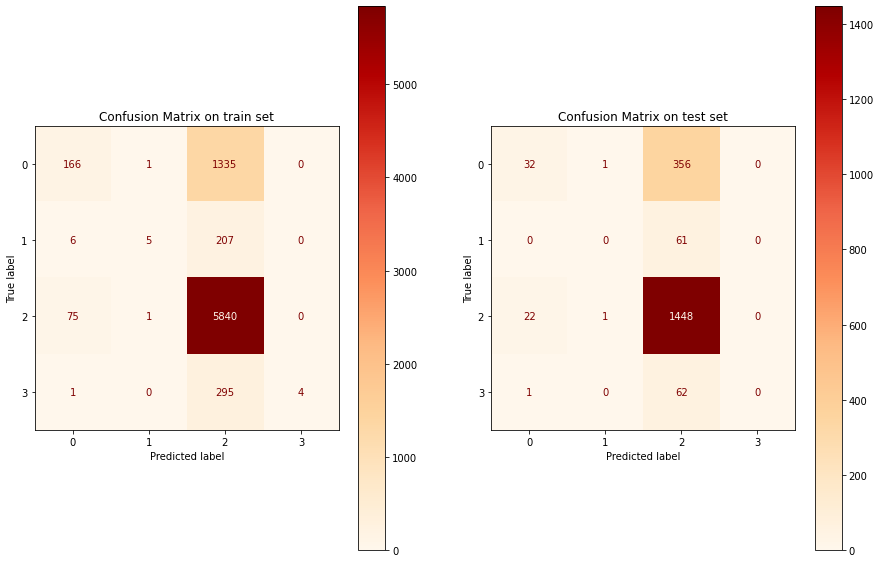

In [ ]:
fig, ax = plt.subplots(ncols= 2, figsize = (15,10))
plot_confusion_matrix(rf_best1, X_train1, y_train1, values_format="d", ax = ax[0], cmap = "OrRd")
plot_confusion_matrix(rf_best1, X_test1, y_test1, ax = ax[1], cmap = 'OrRd', values_format="d")
ax[0].title.set_text("Confusion Matrix on train set")
ax[1].title.set_text("Confusion Matrix on test set")
fig.savefig("drive/MyDrive/Projet Orange/confu_mat1.png")

In [ ]:
print("------ Train set --------")
print(confu_report())

In [ ]:
rf_param = dict(
    bootstrap = [False, True], 
    criterion = ["gini", "entropy"], 
    max_depth = [None, 5, 20], 
    min_samples_leaf = [1, 10], 
    n_estimators = [100, 250, 500], 
    oob_score = [False, True], 
    warm_start = [False, True], 
    )
rf = GridSearchCV(RandomForestClassifier(n_jobs = -1), rf_param, scoring=balanced_score, n_jobs = -1, cv = 3, verbose = False)
rf.fit(X_train2, y_train2)
print('----------------------------------------------------------------')
print(rf.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


----------------------------------------------------------------
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100, 'oob_score': False, 'warm_start': True}


In [ ]:
rf_best2 = RandomForestClassifier(criterion='entropy', n_estimators= 100, oob_score=False, max_depth= 20, warm_start= True)
rf_best2.fit(X_train2, y_train2)
rf_best2_pred = rf_best2.predict(X_test2)
rf_best2_pred_train = rf_best2.predict(X_train2)

In [ ]:
print("Rapport jeu de test")
confu_report(rf_best2_pred,y_test2,  y2_transform)

Rapport jeu de test
Confusion Matrix
 -------------------- 
[[ 39   0   0   1   0   0 164  16  48   0   0]
 [  2   0   0   0   0   0  67   8  27   0   0]
 [  0   0   0   0   0   0  16   7  12   0   0]
 [  2   0   0   0   0   0  14   2   2   0   0]
 [  0   0   0   0   0   0   6   0   0   0   0]
 [  0   0   0   0   0   0  12   3   5   0   0]
 [ 22   2   0   0   0   0 511  69 123   0   0]
 [  7   0   0   0   0   1 235  49  94   0   3]
 [  3   1   0   0   0   0 179  54 116   0   1]
 [  0   0   0   0   0   0   4   0   2   0   0]
 [  0   0   0   0   0   0  27   5  21   0   2]]
 -------------------- 
                   precision    recall  f1-score   support

           Autres       0.52      0.15      0.23       268
          Autres+       0.00      0.00      0.00       104
         Autres++       0.00      0.00      0.00        35
   nbyte_Download       0.00      0.00      0.00        20
  nbyte_Download+       0.00      0.00      0.00         6
 nbyte_Download++       0.00      0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Rapport sur jeu de train")
confu_report(rf_best2_pred_train,y_train2,  y2_transform)

Rapport sur jeu de train
Confusion Matrix
 -------------------- 
[[ 169    1    0    2    0    0  640   37  145    0    0    1]
 [   7    4    0    0    0    0  226   24   93    0    0    1]
 [   4    0    1    0    0    0   58   24   47    0    0    0]
 [   6    0    0    6    0    0   57    2    7    0    0    0]
 [   1    0    0    0    0    0   15    3    2    0    0    0]
 [   3    0    0    0    0    3   79   11   38    0    0    0]
 [  70    0    0    0    0    3 2208  185  404    0    0    1]
 [  22    1    0    1    0    1  908  314  342    0    0    1]
 [  11    0    0    1    0    0  705  177  559    0    0    3]
 [   0    0    0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    5    0    4    0    0    0]
 [   2    0    0    0    0    0  142   33  108    0    0    7]]
 -------------------- 


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

           Autres       0.57      0.17      0.26       995
          Autres+       0.67      0.01      0.02       355
         Autres++       1.00      0.01      0.01       134
   nbyte_Download       0.60      0.08      0.14        78
  nbyte_Download+       0.00      0.00      0.00        21
 nbyte_Download++       0.43      0.02      0.04       134
        nbyte_Web       0.44      0.77      0.56      2871
       nbyte_Web+       0.39      0.20      0.26      1590
      nbyte_Web++       0.32      0.38      0.35      1456
  nbyte_streaming       0.00      0.00      0.00         1
 nbyte_streaming+       0.00      0.00      0.00         9
nbyte_streaming++       0.50      0.02      0.05       292

         accuracy                           0.41      7936
        macro avg       0.41      0.14      0.14      7936
     weighted avg       0.44      0.41      0.36      7936

 -------------------- 


In [ ]:
model_set = pd.concat([pd.DataFrame(X_transform.inverse_transform(X_test2), columns = {"idx_model"}),
           pd.DataFrame(y2_transform.inverse_transform(rf_best2_pred), columns = {"pred"}),
           pd.DataFrame(y2_transform.inverse_transform(y_test2),columns = {"actuel"})
           ], axis = 1)

In [ ]:
model_set[model_set["pred"] == model_set["actuel"]].drop_duplicates()[model_set["pred"] == "nbyte_streaming++"].value_counts()

idx_model  pred               actuel           
1722       nbyte_streaming++  nbyte_streaming++    1
dtype: int64

In [ ]:
rf_param = dict(
    bootstrap = [False, True], 
    criterion = ["gini", "entropy"], 
    max_depth = [None, 5, 20], 
    min_samples_leaf = [1, 10], 
    n_estimators = [100, 250, 500], 
    oob_score = [False, True], 
    warm_start = [False, True], 
    )
rf = GridSearchCV(RandomForestClassifier(n_jobs = -1), rf_param, scoring=balanced_score, n_jobs = -1, cv = 3, verbose = False)
rf.fit(X_train3, y_train3)
print('----------------------------------------------------------------')
print(rf.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


----------------------------------------------------------------
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 250, 'oob_score': True, 'warm_start': True}


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
clfswitcher = make_pipeline(StandardScaler(), ClfSwitcher())
Model1 = GridSearchCV(estimator = clfswitcher , param_grid = parameters, n_jobs = -1, verbose= False, scoring = balanced_score, cv = 3)
Model1.fit(X_train3, y_train3)
print("------- Best parameters --------")
print(Model1.best_params_)

------- Best parameters --------
{'clfswitcher': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False), 'clfswitcher__bootstrap': True, 'clfswitcher__max_depth': 20, 'clfswitcher__n_estimators': 500}


In [ ]:
rf_classif = RandomForestClassifier(max_depth = 20, n_estimators=500)
rf_classif.fit(X_train3, y_train3)
rf_classif_pred = rf_classif.predict(X_test3)
rf_classif_train = rf_classif.predict(X_train3)

In [ ]:
print("--------------- Train Set ----------------")
print(classification_report(y_train3, rf_classif_train))
print("--------------- Test Set ----------------")
print(classification_report(y_test3, rf_classif_pred))

--------------- Train Set ----------------
              precision    recall  f1-score   support

           1       0.65      0.81      0.72      4481
           2       0.59      0.43      0.50      3279
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00       143
           5       0.00      0.00      0.00         1

    accuracy                           0.63      7936
   macro avg       0.25      0.25      0.24      7936
weighted avg       0.61      0.63      0.61      7936

--------------- Test Set ----------------
              precision    recall  f1-score   support

           1       0.63      0.80      0.71      1105
           2       0.57      0.40      0.47       832
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        40

    accuracy                           0.61      1984
   macro avg       0.30      0.30      0.29      1984
weighted avg       0.59      0.61      0.59   

In [ ]:
model_set = pd.concat([pd.DataFrame(X_transform.inverse_transform(X_test3), columns = {"idx_model"}),
           pd.DataFrame(rf_classif_pred, columns = {"pred"}),
           pd.DataFrame(rf_classif_train,columns = {"actuel"})
           ], axis = 1)

In [ ]:
model_set[model_set["pred"] == model_set["actuel"]].drop_duplicates()["pred"].value_counts()#[model_set["pred"] == "nbyte_streaming++"]

1.00    132
2.00     29
Name: pred, dtype: int64